# Segmentation Model for Brain Tumors using Fastai

## Introduction

This notebook is a detailed implementation of a segmentation deep learning algorithm: a model which converts raw medical imaging (in this case MRI scans of brain tumors) into "masks," which are images whose every pixel are labeled. 

The labelling process for each pixel is binary, indicating whether the tumor is illustrated in that pixel or not. When this is done for every pixel, a mask containing the precise location and shape of the tumor results.

The shape of a tumor indicates its genetic characteristics, so a precise segmentation of the medical imaging is useful in determining the severity of the tumor.


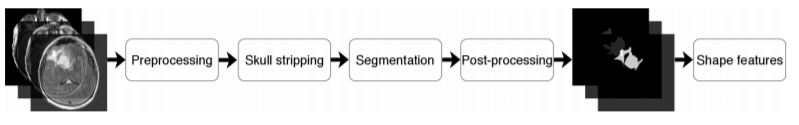

This image is from **[1]** (the paper cited below), and it describes the process in going from raw medical imaging to "shape features," those indicators of the tumor's genomic characteristics. The segmentation stage is an especially labor-intensive process, in which radiologists must manually label each pixel of the medical image, indicating whether the tumor is there or not, in order to produce the mask.

We automize that process with the segmentation algorithm implemented here, thereby allowing radiologists to utilize their expertise more directly (i.e. interpreting the labeling image).

## Imports and Exploring the Data

I am using fastai, a programming framework built on top of PyTorch that allows easy implementation of deep learning algorithms.

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

The following is from Peter Butterfill's notebook "brain-segmentation-fastai." This is done to make the pre-trained model available to the kernel without internet.

In [ ]:
# 1) manually download the model from:
#   * https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /tmp/.cache/torch/checkpoints/resnet34-333f7ec4.pth
# 2) use "+ Add Data" on the kaggle's data panel on the right to make the model available
# 3) make the temp folder (that pytorch wants to use) if it doesn't exist already
Path('/tmp/.cache/torch/checkpoints').mkdir(parents=True, exist_ok=True)
# 4) copy the model from input to the temp folder
!cp /kaggle/input/pytorch-models/resnet34-333f7ec4.pth /tmp/.cache/torch/checkpoints/resnet34-333f7ec4.pth
# 5) then make sure we set path='/kaggle/working' when creating the learner - otherwise it'll use the dir of the model (which is read-only)
output_path = '/kaggle/working'

We want a function which would give us the path and file name of an image's mask given the file name of that image. We can see that the mask's file name is just the raw image's file name with '_mask' added before the suffix. Thus, the function would look something like:

In [ ]:
def get_mask_fn(x): return x.parents[0] / (x.stem + '_mask' + x.suffix)

In [ ]:
# Designating the path to the data
path = Path('/kaggle/input/lgg-mri-segmentation/kaggle_3m')

In [ ]:
# Designating the path to two images we are going to inspect.
image_temp_file = path/'TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_19.tif'
mask_temp_file = get_mask_fn(image_temp_file)

In [ ]:
# Show an example of an image with a tumor
image = open_image(image_temp_file)
image.show(figsize = (5,5))

Now, we want the masks to be normalized so that the pixels of each mask are only 0 or 1, as to indicate whether the tumor is there or not, rather than a range of values between 0-255, where 0 is black (no tumor) and 255 is white (tumor). To open the files like so, we use div = True.

In [ ]:
#Show the mask for that image
mask = open_image(mask_temp_file, div = True)
mask.show(figsize = (5,5))
mask_size = np.array(mask.shape)
image_size = np.array(mask.shape[1:])
mask_size

## Dataset

It would be poor practice to include images from a patient measured in the training set for the validation set because of leakage. Thus, I am specifying certain patients whose images I will use only in the validation set.

In [ ]:
# Validation set must come from patients that the model has not seen before. 
# Thus, I am specifying certain patients for the validation set.
validataion_folders = [
        'TCGA_HT_7694_19950404', 'TCGA_DU_5874_19950510', 'TCGA_DU_7013_19860523',
        'TCGA_HT_8113_19930809', 'TCGA_DU_6399_19830416', 'TCGA_HT_7684_19950816',
        'TCGA_CS_5395_19981004', 'TCGA_FG_6688_20020215', 'TCGA_DU_8165_19970205',
        'TCGA_DU_7019_19940908', 'TCGA_HT_7855_19951020', 'TCGA_DU_A5TT_19980318',
        'TCGA_DU_7300_19910814', 'TCGA_DU_5871_19941206', 'TCGA_DU_5855_19951217']


We are classifying the tumor in two categories:
* t = True, there is a tumor
* f = False, there is no tumor

In [ ]:
codes = ['t','f']

The following is a used to make a customized SegmentationItemList that normalizes the pixel values from 0-255 to 0 or 1, the operation performed by div=True when opening the image.

In [ ]:
# This comes from ilikemath's "Ultrasound Nerve Segmentation with fastai" notebook cited below.
class SegmentationLabelListWithDiv(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)
class SegmentationItemListWithDiv(SegmentationItemList):
    _label_cls = SegmentationLabelListWithDiv

* The following is from fastai's data block API to handle the data.
* The features will be the raw images and the labels will be the masks. Thus, we are fitting a model to convert raw images into segmented, masked images, where each pixel in the masked image is either 't' or 'f' (designated by codes) to indicate whether the pixel is displaying a tumor.

In [ ]:
src = (SegmentationItemListWithDiv
       # get each the data from the folders in this path
       .from_folder(path)
        # the inputs of the data are all files whose name does not end with '_mask.tif' (we are extracting all the raw images)
       .filter_by_func(lambda x: not x.name.endswith('_mask.tif'))
       # designate the validation set as the folders with names listed in validation_folders
       .split_by_valid_func(lambda x: x.parts[-2] in validataion_folders)
       # designate the labels of each raw image as their corresponding masks
       .label_from_func(get_mask_fn, classes = codes))

In [ ]:
data = (src.transform(get_transforms(), size = image_size)
# the batch size is generally dependent of GPU capacity, but 16 is usually a decent number for full-sized images on Kaggle's GPU
        .databunch(bs=16)
        .normalize(imagenet_stats))

A suggestion for an alternative process in training the model is to use progressive resizing:
* integer divide the image_size variable in data above by 2
* fit on the frozen and unfrozen models with half-sized images
* re-instantiate the data variable with a size of image_size
* fit the frozen and unfrozen models with full-sized images

Progressive resizing is a form of transfer learning that assumes that the images with dimensions of half the size are practically an entirely new dataset as the full-sized images. This gives suprisingly good results, and if you want to see the implementation using progressive resizing, I suggest to look at Peter Butterfield's notebook (cited at the end of this notebook).

In [ ]:
data.show_batch(figsize = (7,8))

## Model

We now instantiate the model. We are using a unet architecture, which is state-of-the-art for segmentation problems.

In [ ]:
# wd stands for weight decay- a measure to reduce overfitting
wd = 1e-2

* The dice similarity coefficient metric is a measure of how similar two sample are, in this case, the similarity between two
segmented images. The a high dice value means our prediction is similar to the label (an image manually segmented by a medical school graduate and reviewed by an expert radiologist), so a higher dice value is better.
* The unet is a neural network architecture that stands as a modification of the conventional CNN: it breaks down the input image into feature vectors, then builds up those feature vectors into the output mask image. It is the industry standard for segmentation tasks.

In [ ]:
learn = unet_learner(data, models.resnet34, metrics = dice, wd = wd, path = output_path)

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
learn.save('pre-trained')

The best learning rate can be guessed by the graph as an order of magnitude less than the minimum, but is usually determined experimentally.

In [ ]:
lr = 1e-3
learn.fit_one_cycle(10, lr)

In [ ]:
learn.save('stage-1')

## Second Round: fine-tuning

We are doing the same process on the entire, unfrozen, model. Before, we were only training the last couple layers of the pre-trained model.

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [ ]:
# pct_start means we are applying the cyclic learning rate on only 80% of the epochs. In other words, the feature of 
# fit_one_cycle to increase the learning rate then decrease the learning rate is applied on the epoch with a probability
# of .8.
learn.fit_one_cycle(7, slice(lr/1000, lr/5), pct_start = .8)

In [ ]:
learn.save('stage-2')

In [ ]:
# let's inspect the results now
learn.show_results(rows = 3, figsize = (8,8))

# Discussion and Conclusion: why did we do this?
 
According to **[1]** (paper cited below), the mean dice value between segmentations of two expert radiologists is 84%. The mean dice value between the output of our model and masks segmented by a medical school graduate and reviewed by an expert radiologist (representing the dataset here) is in the upper 70's. We can reach higher levels with additional fine-tuning and implementing  the progressive resizing method as mentioned above, but it stands that our model is on par with expert radiologists.

So, why did we do this? Having an automated segmentation process not only cuts down the tedious, time-consuming labor of valuable radiologists, freeing them to give more value with their expertise, but also confers valuable information of the patient inexpensively and more rapidly.

A quickly-accessible segmentation image stands as extra information early in the surgical process. Even if the image's predictive power were only moderate, this extra information nevertheless allows guidance of the patient's next steps.

The diagnosis of an extremely aggressive tumor from the medical imaging would provide reason to immediately act to remove the tumor. If the diagnosis indicates a mild tumor, it would be best to engage in further genetic testing. Information from medical imaging also serves to validate or call into question the results taken from a local biopsy.

Thus, in addition to determining whether the patient has a tumor in the first place, medical imaging, and this segmentation algorithm which facilitates it, serve as noninvasive, pre-surgical methods to acquire further information about the tumor that informs subsequent steps in the surgical process.

## References and Citations

> Thank you to these two notebooks for more or less serving as references for my code: (give these guys an upvote)
*     https://www.kaggle.com/tanlikesmath/ultrasound-nerve-segmentation-with-fastai
*     https://www.kaggle.com/peter88b/brain-segmentation-fastai

> And thank you to the following papers for providing information about the segmentation process:
* Mateusz Buda, AshirbaniSaha, Maciej A. Mazurowski "Association of genomic subtypes of lower-grade gliomas with shape features automatically extracted by a deep learning algorithm." Computers in Biology and Medicine, 2019. **[1]**